<a href="https://colab.research.google.com/github/Bempong-Sylvester-Obese/Food-segmentation-with-pre-trained-model/blob/main/Food_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ENVIRONEMNT SETUP**

In [ ]:
import os
import torch
import sys
import shutil

# Device and GPU setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Project Repository
ROOT_CONTENT_DIR = "/content"

# remove any existing /content/content directory
NESTED_CONTENT_DIR = os.path.join(ROOT_CONTENT_DIR, "content")
if os.path.exists(NESTED_CONTENT_DIR):
    print(f"Removing existing nested content directory: {NESTED_CONTENT_DIR}")
    shutil.rmtree(NESTED_CONTENT_DIR)


PROJECT_DIR_NAME = "food_segmentation"
PROJECT_DIR = os.path.join(ROOT_CONTENT_DIR, PROJECT_DIR_NAME)

# Remove existing project directory
if os.path.exists(PROJECT_DIR):
    print(f"Removing existing project directory: {PROJECT_DIR}")
    shutil.rmtree(PROJECT_DIR)

# Create the project directory and change into it
os.makedirs(PROJECT_DIR, exist_ok=True)
os.chdir(PROJECT_DIR)
ABS_PROJECT_DIR = os.getcwd()

sys.path.append(ABS_PROJECT_DIR)

print("Cloning model repositories..")
!git clone https://github.com/IDEA-Research/GroundingDINO.git GroundingDINO
!git clone https://github.com/ChaoningZhang/MobileSAM.git MobileSAM

# Dependency Installation
print("Installing dependencies")
!pip install -q -e ./GroundingDINO
!pip install -q -e ./MobileSAM

# Model weight download
print("Downloading model weights..")

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth -P ./GroundingDINO
!wget -q https://github.com/ChaoningZhang/MobileSAM/raw/master/weights/mobile_sam.pt -P ./MobileSAM

print("\nSetup complete.")

LOADING MODEL

In [ ]:
import supervision as sv
import sys
import os

# Add GroundingDINO directory to sys.path
grounding_dino_dir = os.path.join(ABS_PROJECT_DIR, "GroundingDINO")
if grounding_dino_dir not in sys.path:
    sys.path.append(grounding_dino_dir)
    print(f"Added {grounding_dino_dir} to sys.path")

# Add MobileSAM directory to sys.path
mobile_sam_dir = os.path.join(ABS_PROJECT_DIR, "MobileSAM")
if mobile_sam_dir not in sys.path:
    sys.path.append(mobile_sam_dir)
    print(f"Added {mobile_sam_dir} to sys.path")

try:
    from groundingdino.util.inference import Model as GroundingDINO
except ModuleNotFoundError as e:
    print(f"Error importing GroundingDINO model: {e}")
    sys.exit("Could not import GroundingDINO model.")


from mobile_sam import sam_model_registry, SamPredictor

# GroundingDINO configuration
GROUNDING_DINO_CONFIG_PATH = os.path.join(ABS_PROJECT_DIR, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
GROUNDING_DINO_CHECKPOINT_PATH = os.path.join(ABS_PROJECT_DIR, "GroundingDINO/groundingdino_swint_ogc.pth")

# MobileSAM configuration
MOBILE_SAM_CHECKPOINT_PATH = os.path.join(ABS_PROJECT_DIR, "MobileSAM/mobile_sam.pt")
SAM_TYPE = "vit_t"

print("Loading GroundingDINO model..")
grounding_dino_model = GroundingDINO(GROUNDING_DINO_CONFIG_PATH, GROUNDING_DINO_CHECKPOINT_PATH, DEVICE)

print("Loading MobileSAM model..")
sam = sam_model_registry[SAM_TYPE](checkpoint=MOBILE_SAM_CHECKPOINT_PATH)
sam.to(DEVICE)
sam_predictor = SamPredictor(sam)

print("\nModels loaded successfully")

IMAGE DEFINITION AND TEXT PROMPTS

Using image path from: /content/food_segmentation/Raw Images/11dbf428-meal_image_31782_2023-08-10_30_40_75.jpg
Image file found at /content/food_segmentation/Raw Images/11dbf428-meal_image_31782_2023-08-10_30_40_75.jpg


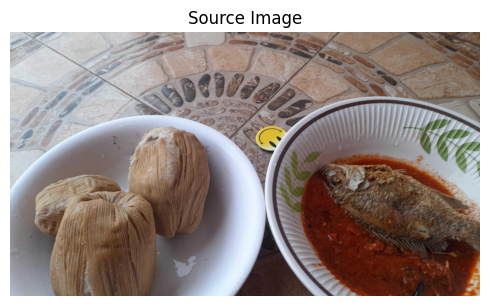

In [15]:
import os
import requests
import cv2
import matplotlib.pyplot as plt
import math

# Image path
IMAGE_NAME = "/content/food_segmentation/Raw Images/11dbf428-meal_image_31782_2023-08-10_30_40_75.jpg"

IMAGE_PATH = os.path.join(ABS_PROJECT_DIR, IMAGE_NAME)


print(f"Using image path from: {IMAGE_PATH}")

# Check if the image file exists
if not os.path.exists(IMAGE_PATH):
    print(f"Error: Image file not found at {IMAGE_PATH}")
else:
    print(f"Image file found at {IMAGE_PATH}")
    # Text Prompt
    CLASSES =["Kenkey, Tilapia and pepper stew"]
    PROMPT = "Three balls of kenkey, steamed tilapia and pepper stew"

    # Visualisation helper function
    def show_image(images, titles=None, cols=2):
        rows = math.ceil(len(images) / cols)
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
        axes = axes.flatten() if rows > 1 or cols > 1 else [axes]

        for i, img in enumerate(images):
            axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            if titles and i < len(titles):
                axes[i].set_title(titles[i])
            axes[i].axis('off')

        # Hide any unused subplots
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.tight_layout()
        plt.show()


    source_image = cv2.imread(IMAGE_PATH)
    show_image([source_image], titles=["Source Image"], cols=1)

INFERENCE PIPELINE

In [ ]:
import numpy as np
import torch
import supervision as sv

# Detect with GroundingDINO
print("Running GroundingDINO detection..")
detections, _, = grounding_dino_model.predict_with_caption(
    image=source_image,
    caption=PROMPT,
    box_threshold=0.35,
    text_threshold=0.25
)
print(f"Detected {len(detections)} objects.")

if len(detections) > 0:
    detections.class_id = np.zeros(len(detections), dtype=int)
    if detections.confidence is None:
        detections.confidence = np.ones(len(detections))
    else:
        detections.confidence = np.array(detections.confidence)
else:
    detections.class_id = np.array([], dtype=int)
    detections.confidence = np.array([])


print("Running MobileSAM segmentation...")

# Set image for SAM predictor
sam_predictor.set_image(cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB))

# GroundingDINO detections as input boxes for SAM
if len(detections) > 0:
    input_boxes = detections.xyxy
else:
    input_boxes = np.array([])

masks = []

# predict mask individually
if len(input_boxes) > 0:
    for box in input_boxes:
        box = box.reshape(1, -1)
        mask, scores, logits = sam_predictor.predict(
            point_coords=None,
            point_labels=None,
            box=box,
            multimask_output=False, # one mask per bounding box
        )
        if isinstance(mask, torch.Tensor):
            mask = mask.cpu().numpy()
        masks.append(np.squeeze(mask))


# Connect masks into a single array
if len(masks) > 0:
    masks = np.array(masks)
    print(f"Generated {masks.shape[0]} masks.")
else:
    masks = np.array([])
    print("No masks generated.")


# Link Detections and Masks
if len(detections) > 0 and len(masks) == len(detections):
    detections.mask = masks
elif len(detections) > 0 and len(masks) != len(detections):
     print("Warning: Mask count does not match detection count.")
     detections.mask = np.array([])
else:
    detections.mask = np.array([])
    print("No detections or masks.")


# Filter any empty detections
if detections.mask is not None and isinstance(detections.mask, np.ndarray) and detections.mask.shape[0] > 0:
    detections = detections[detections.mask.sum(axis=(1, 2)) > 0]
else:
    detections = sv.Detections.empty()

print(f"Final number of detections with masks: {len(detections)}")

RESULT VISUALIZATION


Displaying Results:


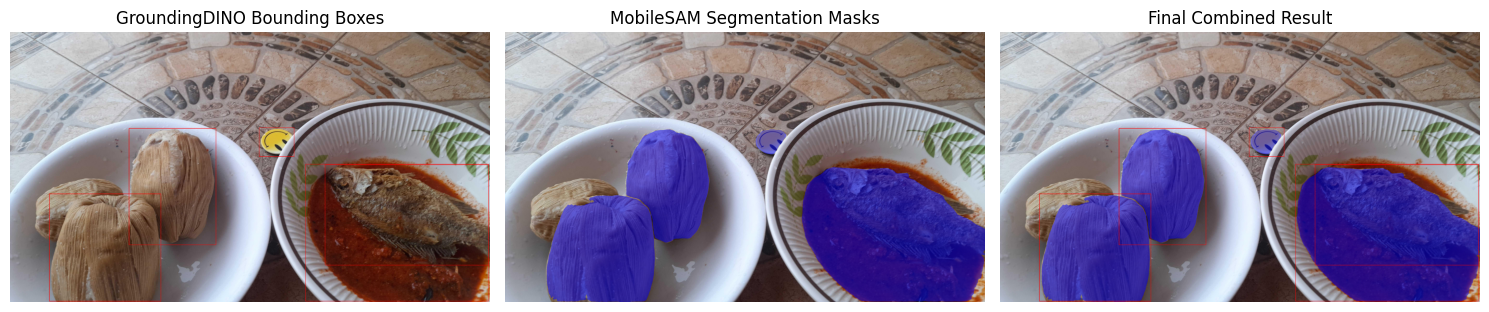

In [17]:
import supervision as sv
import os
import cv2
import numpy as np

box_annotator = sv.BoxAnnotator(color=sv.Color(b=0, g=0, r=255), thickness=2) # BGR for Red
mask_annotator = sv.MaskAnnotator(color=sv.Color(b=255, g=0, r=0)) # BGR for Blue

# Annotation with bounding boxes
annotated_image_boxes = box_annotator.annotate(
    scene=source_image.copy(),
    detections=detections,
)

# Annotate with masks
annotated_image_masks = mask_annotator.annotate(
    scene=source_image.copy(),
    detections=detections
)

# 3. Annotate with both boxes and masks
combined_annotated_image = mask_annotator.annotate(
    scene=source_image.copy(),
    detections=detections
)
combined_annotated_image = box_annotator.annotate(
    scene=combined_annotated_image,
    detections=detections,
)

print("\nDisplaying Results:")

# Create results directory if it doesn't exist
results_dir = os.path.join(ABS_PROJECT_DIR, "results")
os.makedirs(results_dir, exist_ok=True)

# Display the annotated images in a grid
images_to_display = [
    annotated_image_boxes,
    annotated_image_masks,
    combined_annotated_image
]
titles_for_display = [
    "GroundingDINO Bounding Boxes",
    "MobileSAM Segmentation Masks",
    "Final Combined Result"
]

show_image(images_to_display, titles=titles_for_display, cols=3) # Display in 3 columns